<h1><center>Kats 202 Detection Algorithm</center></h1>
This notebook provides advanced tutorial on detection algorithm available in Kats, including: change point detection, outlier detection and trend detection. The table of content is listed below:

* 1. [Changepoint Detection](#1.-Changepoint-Detection-)
    * 1.1 [CUSUMDetector](#1.1-CUSUMDetector)
    * 1.2 [BOCPDetector](#1.2-BOCPDetector)
    * 1.3 [RobustStatDetector](#1.3-RobustStatDetector)
    * 1.4 [Comparing the Changepoint Detectors](#1.4-Comparing-the-Changepoint-Detectors)
* 2. [Outlier Detection](#2.-Outlier-Detection)
    * 2.1 [OutlierDetector](#2.1-OutlierDetector)
    * 2.2 [MultivariateAnomalyDetector](#2.2-MultivariateAnomalyDetector)
    * 2.3 [HourlyRatioDetector](#2.3-HourlyRatioDetector)
* 3. [Trend Detection](#3.-Trend-detection)
    * 3.1 [MKDetector](#3.1-MKDetector)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from imp import reload
from datetime import datetime, timedelta
import sys
sys.path.append("../")

from kats.consts import TimeSeriesData
reload(logging)

<module 'logging' from '/opt/homebrew/Cellar/python38/3.8.3_1/Frameworks/Python.framework/Versions/3.8/lib/python3.8/logging/__init__.py'>

# 1. Changepoint Detection <a class="anchor" id="kats_basics"></a>

Changepoint detection tries to identify times when the probability distribution of a stochastic process or time series changes, e.g. the change of mean in a time series. It is one of the most popular detection tasks in time series analysis. 

## **1.1 CUSUMDetector**

CUSUMDetector is used for detecting sudden and sustain mean shift(up/down) in the time series. In Kats implementation, it has two main components:

1. Locate the change point: The algorithm iteratively estimates the means before and after the change point and finds the change point maximizing/minimizing the cusum value until the change point has converged. The starting point for the change point is at the middle.
2. Hypothesis testing: Conducting log likelihood ratio test where the null hypothesis has no change point with one mean and the alternative hypothesis has a change point with two means.

And here are a few things worth mentioning:

* We assume there is only one increase/decrease change point, i.e. one detector can maximally return one increase change point and one decrease change point;
* We use Gaussian distribution as the underlying model to calculate the cusum value and conduct the hypothesis test;


### Parameters for detector( ) method
* **threshold**: float, significance level;
* **max_iter**: int, maximum iteration in finding the changepoint;
* **delta_std_ratio**: float, the mean delta has to be larger than this parameter times std of the data to be considered as a change;
* **min_abs_change**: int, minimal absolute delta between mu0 and mu1
* **start_point**: int, the start idx of the changepoint, None means the middle of the time series;
* **change_directions**: list\[str], a list contain either or both 'increase' and 'decrease' to specify what type of change to be detected;
* **interest_window**: list\[int, int], a list containing the start and end of the interest window where we will look for a change point. Note that the llr will still be calculated using all data points;
* **magnitude_quantile**: float, the quantile for magnitude comparison, if none, will skip the magnitude comparison;
* **magnitude_ratio**: float, comparable ratio;
* **magnitude_comparable_day**: float, maximal percentage of days can have comparable magnitude to be considered as regression;
* **return_all_changepoints**: bool, return all the changepoints found, even the insignificant ones.

### Basic usage

In [12]:
# import packages
from kats.detectors.cusum_detection import CUSUMDetector

# synthesize data with simulation
np.random.seed(10)
df_increase_decrease = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', periods=60),
        'increase':np.concatenate([np.random.normal(1,0.2,30), np.random.normal(2,0.2,30)]),
        'decrease':np.concatenate([np.random.normal(1,0.3,50), np.random.normal(0.5,0.3,10)]),
    }
)

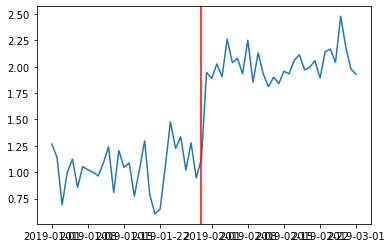

In [13]:
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector()
detector.plot(change_points)

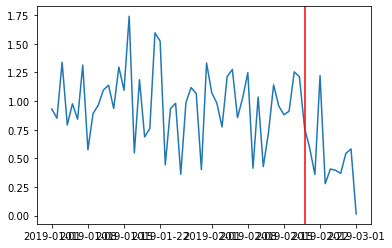

In [14]:
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','decrease']])
detector = CUSUMDetector(tsd)
change_points = detector.detector()
detector.plot(change_points)

### Interpret the result
The detector method returns `List[Tuple[TimeSeriesChangePoint, CUSUMMetadata]]`. Most detectors in Kats return the same structure, while each detector will have their own Metadata.

In [15]:
# Get the change point and metadata, since we only detected one change point 
# above we can 
change_point, metadata = change_points[0]
change_point

TimeSeriesChangePoint(start_time: 2019-02-19 00:00:00, end_time: 2019-02-19 00:00:00, confidence: 0.9999386805454802)

The metadata is consisted of property:
* direction: the change point direction increase or decrease;
* cp_index: the index of the change point;
* mu0: mean before the change point;
* mu1: mean after the change point;
* delta: mu1 - mu0;
* llr_int: the log likelihood ratio in interest window(will explain interest window in next section);
* llr: the log likelihood ratio for the full time series;
* regression_detected: is the change point detected by the algorithm(only useful when set `return_all_changepoints` True);
* stable_changepoint: is the change point locating algorithm converged;
* p_value: p value for the likelihood ratio test;
* p_value: p value for the likelihood ratio test in interest_window.

In [16]:
metadata.__dict__

{'_direction': 'decrease',
 '_cp_index': 49,
 '_mu0': 0.9771190741700813,
 '_mu1': 0.47545844508033436,
 '_delta': -0.501660629089747,
 '_llr_int': inf,
 '_llr': 19.39882679926723,
 '_regression_detected': True,
 '_stable_changepoint': True,
 '_p_value': 6.13194545198148e-05,
 '_p_value_int': nan}

### Interest Window & Daily Seasonality
In some cases, you might want to use more information from historical data, but not detecting change point in the historical data. You can use the argument `interest_window` to tell the algorithm what's the range do you want to find change points in.

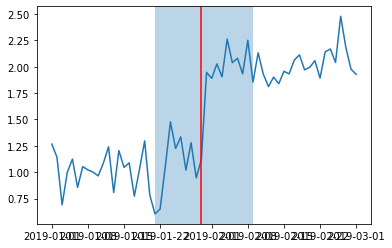

In [17]:
# limit the interest_window between 20th and 40th data point
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(interest_window=[20,40])
detector.plot(change_points)

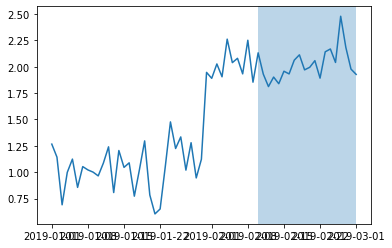

In [18]:
# limit the interest_window to last 20 the datapoint and no change point detected
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(interest_window=[40,60])
detector.plot(change_points)

In many use cases there are seasonality and will introduce false positive to the algorithm. To address this problem we compare the daily magnitude with days in the historical window.

In [19]:
# synthesize seasonal data with simulation
def simulate_seasonal_term(
    periodicity, total_cycles, noise_std=1.0, harmonics=None
):
    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration  # Pad for burn in
    series = np.zeros(total_timesteps)
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (
                gamma_jt[j - 1] * cos_j
                + gamma_star_jt[j - 1] * sin_j
                + noise_std * np.random.randn()
            )
            gamma_star_jtp1[j - 1] = (
                -gamma_jt[j - 1] * sin_j
                + gamma_star_jt[j - 1] * cos_j
                + noise_std * np.random.randn()
            )
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:]  # Discard burn in

    return wanted_series

np.random.seed(1)
periodicity = 24
total_cycles = 3
harmonics = 2
noise_std = 3

seasonal_term = simulate_seasonal_term(
    periodicity, total_cycles, noise_std=noise_std, harmonics=harmonics
)
seasonal_term = seasonal_term / seasonal_term.std() * 2
residual = np.random.normal(0, 1, periodicity * total_cycles)
data = seasonal_term + residual
data -= np.min(data)

df_seasonality = pd.DataFrame(
    {
        "time": pd.date_range(
            "2020-01-01", periods=periodicity * total_cycles, freq="H"
        ),
        "seasonality": data,
    }
)
timeseries = TimeSeriesData(df_seasonality)
detector = CUSUMDetector(timeseries)

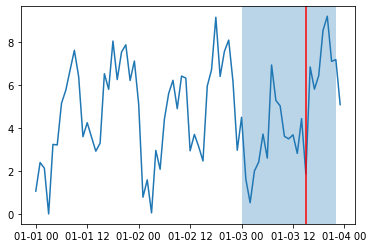

In [20]:
# Without magnitude comparison
change_points = detector.detector(
    interest_window=[
        periodicity * (total_cycles - 1),
        periodicity * total_cycles - 1,
    ],
    change_directions=["increase"],
)
detector.plot(change_points)

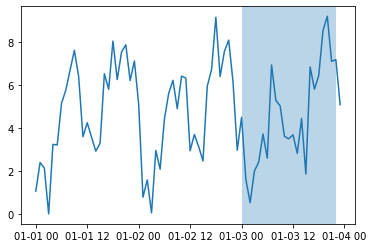

In [21]:
# With magnitude comparison, seasonal false psoitive not detected
change_points = detector.detector(
    interest_window=[
        periodicity * (total_cycles - 1),
        periodicity * total_cycles - 1,
    ],
    magnitude_quantile=1, # enable magnitude comparison
    change_directions=["increase"],
)
detector.plot(change_points)

### Detecting multiple change points
In most use cases, there are more than one change point, and you might want to monitor the regressions continuously. Here shows how can we achieve detecting multiple change points over time.

In [22]:
# synthesize data with simulation
np.random.seed(10)
df_multi_cps = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', periods=100),
        'y':np.concatenate([
            np.random.normal(1, 0.2, 30), 
            np.random.normal(2, 0.2, 30),
            np.random.normal(0, 0.2, 20),
            np.random.normal(3, 1, 20),
        ]),
    }
)

In [23]:
historical_window = 20
scan_window = 10
step = 5
changepoints = []
n = len(df_multi_cps)
for end_idx in range(historical_window + scan_window, n, step):
    tsd = TimeSeriesData(df_multi_cps.iloc[end_idx - (historical_window + scan_window) : end_idx])
    changepoints += CUSUMDetector(tsd).detector(insterest_window=[historical_window, len(tsd)])

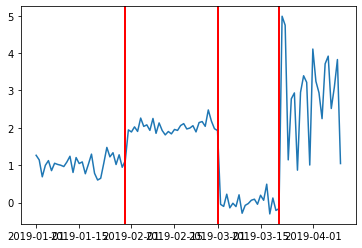

In [24]:
# plot the results
tsd = TimeSeriesData(df_multi_cps)
detector = CUSUMDetector(tsd)
detector.detector()
detector.plot(changepoints)

## **1.2 BOCPDetector**

Bayesian online changepoint detection is a method for detecting changes in a time series. The detector tries to detect sudden changes in a time series that persist over a period of time. Compared to other changepoint detection methods, this method has some unique features:

* This is an online model. As new data arrives, it revises its predictions. It only needs to look at few steps ahead(specified by the user) to detect, and does not need the entire time series apriori.
* Since this is a Bayesian model, the user can specify their prior belief about the probability of a changepoint, as well as the parameters of the underlying model governing the time series.
This faithfully implements the algorithm in Adams & McKay, 2007. "Bayesian Online Changepoint Detection" (https://arxiv.org/abs/0710.3742).

The basic idea is to see whether the new values are improbable, when compared to a Bayesian predictive model, built from the previous observations.

There are two different classes the user needs to specify. The first is a changepoint detection class, and the second one is the underlying predictive model(UPM). The UPM specifies the generative model, from which successive points in the time series are generated from.

For the changepoint detection model, the user needs to specify:

* The data, which is a univariate time series
* the lag, which specifies how many steps to look ahead to find the changepoint
For the underlying predictive model, currently we only support a Normal distribution with unknown mean, known variance. We will add more distributions in the future. For the UPM, the user needs to specify:

* whether to use empirical prior, derived from the data
* If not using empirical prior, user needs to specify the mean and precision of the prior distribution of the mean, as well the known precision. The model is formulated in terms of precision (which is the inverse of variance) for convenience

### Parameters for detector( ) method
* **model**: This specifies the probabilistic model, that generates the data within each segment. The user can input several model types depending on the behavior of the time series. Currently, allowed models are:
    * NORMAL_KNOWN_MODEL: Normal model with variance known. Use this to find level shifts in normally distributed data.
    * TREND_CHANGE_MODEL : This model assumes each segment is generated from ordinary linear regression. Use this model to understand changes in slope, or trend in time series.
    * POISSON_PROCESS_MODEL: This assumes a Poisson generative model. Use this for count data, where most of the values are close to zero.

* **model_parameters**: Model Parameters correspond to specific parameters for a specific model. They are defined in the NormalKnownParameters, TrendChangeParameters, PoissonModelParameters classes.

* **lag**: integer referring to the lag in reporting the changepoint. We report the changepoint after seeing "lag" number of data points. Higher lag gives greater certainty that this is indeed a changepoint. Lower lag will detect the changepoint faster. This is the trade-off.

* **changepoint_prior**: This is a Bayesian algorithm. Hence, this parameter specifies the prior belief on the probability that a given point is a changepoint. For example, if you believe 10% of your data will be a changepoint, you can set this to 0.1.

* **threshold**: We report the probability of observing the changepoint at each instant. The actual changepoints are obtained by denoting the points above this threshold to be a changepoint.

* **debug**: This surfaces additional information, such as the plots of predicted means and variances, which allows the user to see debug why changepoints were not properly detected.

### Basic Usage
Here we show the basic usage of BOCPDetector to detect mean shift.

In [25]:
# import packages
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# synthesize data with simulation
def make_ts():
    np.random.seed(seed=100)# constants
    sigma = 1
    t_start = 0
    t_end = 450#calculation
    num_points = t_end - t_start
    y_val = np.random.normal(loc=1.35, scale=0.05, size=num_points)# make changepoints
    y_val[100:200] = y_val[100:200] - 0.2
    y_val[350:450] = y_val[350:450] - 0.15
    df = pd.DataFrame({'time': pd.date_range('2020-01-01', periods=num_points, freq='H'), 'value': y_val })

    return df
df_bocpd = make_ts()

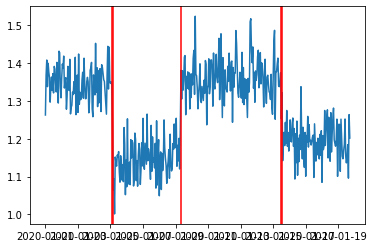

In [26]:
# use the same data above
tsd = TimeSeriesData(df_bocpd)
detector = BOCPDetector(tsd)
changepoints = detector.detector()
detector.plot(changepoints)

### Interpret the results

In [27]:
cp, meta = changepoints[0]
cp

TimeSeriesChangePoint(start_time: 2020-01-05T02:00:00.000000000, end_time: 2020-01-05T02:00:00.000000000, confidence: 0.9748642112729835)

The BOCPDMetadata tells you the detector type, model type and the name of the time series

In [28]:
meta.__dict__

{'_detector_type': kats.detectors.bocpd.BOCPDetector,
 '_model': <BOCPDModelType.NORMAL_KNOWN_MODEL: 1>,
 '_ts_name': 'value'}

## **1.3 RobustStatDetector**

RobustStatDetector is also a method to detect mean shift. It first smooths the data using moving average and takes the diff of the time series and calculate z-score on it. Based on the p-value on each data point, it will flag the ones with p-value smaller than the threshold.

### Parameters for detector( ) method
* **p_value_cutoff**: float, the p-value threshold to flag the change point; 
* **smoothing_window_size**: int, the length of the smoothing window;
* **comparison_window**: int, the step of the diff function, i.e. how many data point you want the algorithm look back and make the comparison.

### Baisc Usage

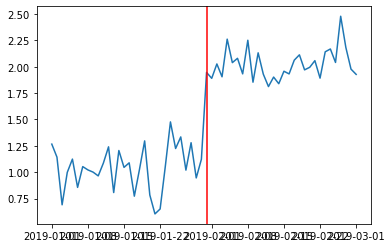

In [29]:
# import package
from kats.detectors.robust_stat_detection import RobustStatDetector

tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = RobustStatDetector(tsd)
changepoints = detector.detector()
detector.plot(changepoints)

### Multiple Changepoints
The RobustStatDetector can detect multiple change points in one time series by one run. But one cautious here is that the algorithm will use the full time series to compute the z-score, which means it might affect the results negatively, e.g. it might not be able to detect a smaller change when there is a bigger change in the time series.

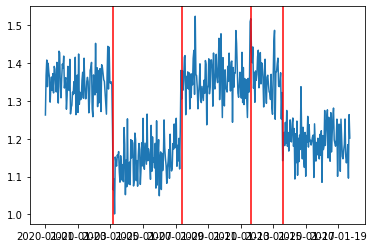

In [30]:
tsd = TimeSeriesData(df_bocpd)
detector = RobustStatDetector(tsd)
changepoints = detector.detector(p_value_cutoff = 5e-3, comparison_window=2)
detector.plot(changepoints)

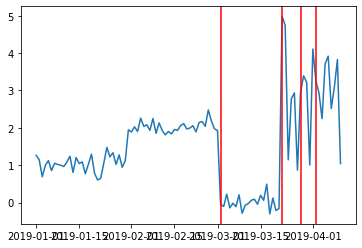

In [31]:
tsd = TimeSeriesData(df_multi_cps)
detector = RobustStatDetector(tsd)
# even setting the p_value to be 0.1 it cannot detect the first change point, while there are already many FPs in the results
changepoints = detector.detector(p_value_cutoff = 1e-1, comparison_window=2)
detector.plot(changepoints)

To avoid this we can again use the same way in CUSUMDetector to detect multiple change points by cutting the long time sereis into several different shorter sections.

# 2. Outlier Detection
Outliers in Time Series can cause a lot of issues in downstream processing. Therefore, removing outliers is important in any time series analysis. In Kats, we have three algorithms detecting outliers, one for univariate time series, one for multi-variate time series and one for detecting irregular daily patterns.

## **2.1 OutlierDetector**
In OutlierDetector we have implemented an outlier detection algorithm which mimics the outlier detection algorithm in R. The steps are outlined as follows:

* We do a time series decomposition of the input time series with additive or multiplicative decomposition as specified
* We generate a residual time series by either removing only trend or both trend and seasonality based on the strength of the seasonality in the time series.
* We detect points in the residual which are outside 3 times the inter quartile range. We can tune the outlier detection to incorporate less or more outliers by tuning this parameter

### Parameters when initial the detector
* **data**: TimeSeriesData object with the time series
* **decomp**: str, 'additive' or 'multiplicative'
* **iqr_mult**: float iqr_mult * inter quartile range is used to classify outliers

### Basic usage

In [34]:
from kats.detectors.outlier import OutlierDetector
# inject trend and outlier to the seasonality data
df_outlier = df_seasonality.copy()
df_outlier.seasonality = df_outlier.seasonality + np.linspace(0, 20, 72)
df_outlier.loc[30, 'seasonality'] = df_outlier.seasonality.iloc[30] * 2.5

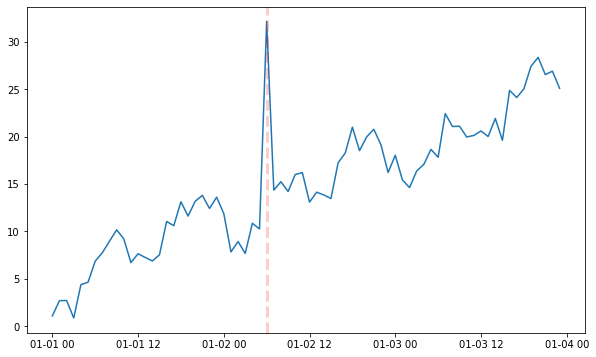

In [36]:
tsd = TimeSeriesData(df_outlier)
detector = OutlierDetector(tsd, decomp='additive', iqr_mult=3.0)
detector.detector()
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(tsd.time, tsd.value)
# detector.outliers[0] includes all the outlier it detected
for i in detector.outliers[0]:
    dt = datetime.strftime(i, "%Y-%m-%d")
    ax.axvline(i, linewidth=3, linestyle = '--', color='red', alpha = 0.2)

## **2.2 MultivariateAnomalyDetector**
This anomaly detection method is useful to detect anomalies across multiple time series. Anomalies are detected based on deviations from the predicted steady state behavior. The steady state behavior of a system of metrics is predicted by modeling the linear interdependencies between time-series using a VAR model. This approach is especially suited for detecting multivariate anomalies - small anomalies but persistent across a large number of time series.

In addition to identifying an anomalous event, this method has useful utilities to flag specific time series that were affected for a high level root cause analysis. For more details about the approach, please refer to this note.

### Parameters when initial the detector
* **data**: TimeSeriesData - Note that data should be deseasonalized and detrended prior to detection
* **params**: `VARParams` class initiated with appropriate parameters for the VAR model training
* **training_days**: Initial number of days (can be a fraction) to use for training the model. As a result, the first selected number of data points will be excluded from the results.

### VARParams
* **maxlags**: Maximum number of lags to check for order selection, defaults to 12 * (nobs/100.)**(1./4)
* **method**: Estimation method to use, defaults to OLS
* **ic**: Information criterion to use for VAR order selection, defaults to None
* **trend**: 
    * “c” - add constant (Default), 
    * “ct” - constant and trend, 
    * “ctt” - constant, linear and quadratic trend,  
    * “n”/“nc” - no constant, no trend

### Basic usage

In [39]:
from kats.detectors.outlier import MultivariateAnomalyDetector, MultivariateAnomalyDetectorType
from kats.models.var import VARParams
from kats.models.bayesian_var import BayesianVARParams
import statsmodels.api as sm
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR
import statsmodels.tsa.vector_ar.util as util

In [40]:
# Simulating VAR(2) process by fitting VAR(2) model to macroeconomic data
# load macroeconomic data and preprocess (make it stationary)
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str) # prepare the dates index
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv','realgovt', 'realdpi','cpi', 'm1','unemp','pop']]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

# fit VAR(2) model and get coeffs and residual covariance of VAR(2) model
model = VAR(data)
results = model.fit(2)

# simulate VAR(2) data from model parameters estimated above
def simulate_var(results, steps=None, offset=None, seed=None):
    steps_ = None
    if offset is None:
        offset = results.intercept

    y = util.varsim(results.coefs, offset, results.sigma_u, steps=steps, seed=seed)
    return y

y = simulate_var(results, steps=1000, seed=42)
df = pd.DataFrame(y.copy())

/Users/iamxiaodong/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.



In [41]:
# Add events
# Add offsets to make it easy to see metrics
i=0
for col in df.columns:
    df[col]= df[col]+col/10
    i+=1

# Add spikes to a 3 time series
affected_columns = [0, 5, 6]
for col in affected_columns:
    df.loc[900:910, col]= 1.1* np.percentile(df[col], 75)
df = df+1

# Add level shift to 2 metrics
affected_columns = [1,3]
for col in affected_columns:
    df.loc[600:, col]= df.loc[600:, col] - np.abs(df[col].mean()-1.1* np.percentile(df[col], 60))
df = df+1

df['time'] = list(pd.date_range(end='2020-02-01', periods=df.shape[0]))


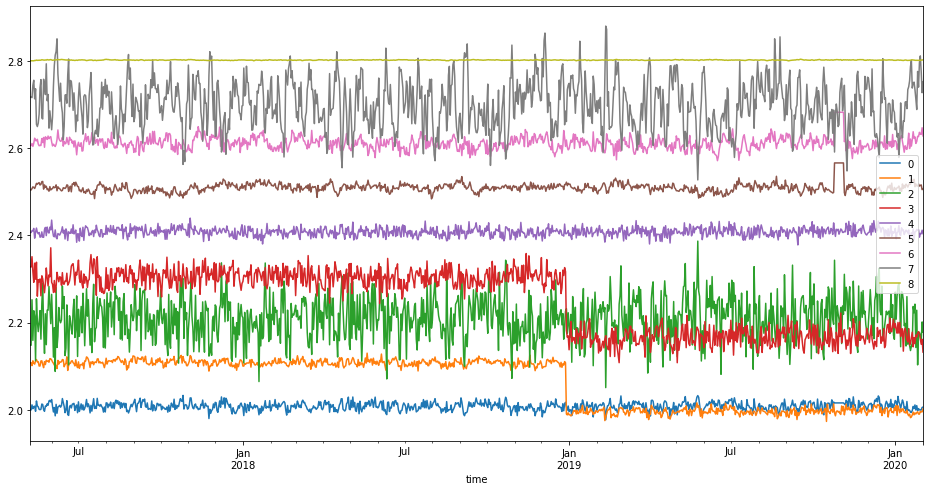

In [42]:
# plot data
fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=1)
df.set_index('time').plot(ax=ax)
plt.show()

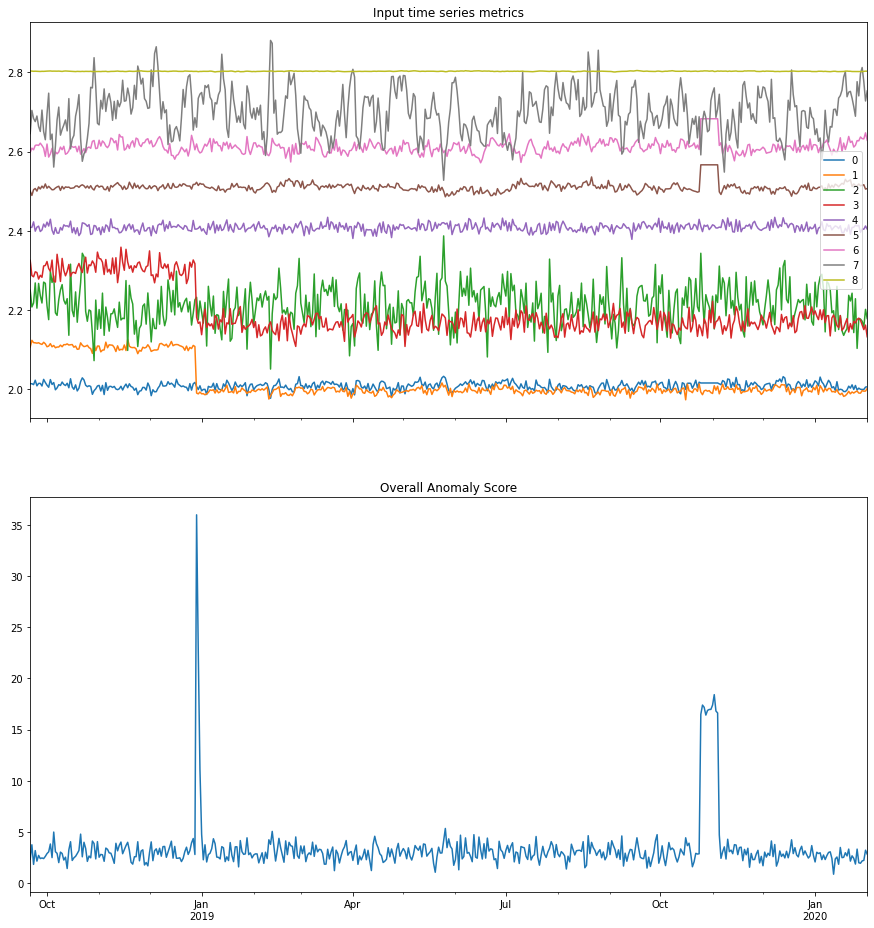

In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.basicConfig(level=logging.ERROR)

TSData_multi = TimeSeriesData(df)

params = VARParams(maxlags=2)
d = MultivariateAnomalyDetector(TSData_multi, params, training_days=500)
anomaly_score_df = d.detector()
d.plot()

In [44]:
anomaly_score_df.head()

,0,1,2,3,4,5,6,7,8,overall_anomaly_score,p_value
2018-09-21,0.022052,1.513414,0.761288,1.094626,1.008991,0.590285,0.134673,0.211551,0.312031,2.331986,0.985066
2018-09-22,0.708806,1.829566,0.500942,0.599909,0.376042,1.242125,0.835920,0.685205,1.335378,3.747966,0.927204
2018-09-23,0.454032,0.679727,0.753149,0.705968,0.658061,0.875221,0.043642,0.192603,0.873214,1.831724,0.993858
2018-09-24,0.170697,0.137146,0.028099,0.558495,1.615973,1.279420,1.109271,0.313944,0.231969,3.180700,0.956698
2018-09-25,0.109329,0.842202,0.279845,0.139882,0.653411,0.735009,0.493126,0.356125,1.050604,2.149679,0.988873


In [45]:
# get anomalies by setting desired segnificance level (alpha)
alpha = 0.05
anomalies = d.get_anomaly_timepoints(alpha)
anomalies

[Timestamp('2018-12-29 00:00:00'),
 Timestamp('2018-12-30 00:00:00'),
 Timestamp('2019-10-26 00:00:00'),
 Timestamp('2019-10-27 00:00:00'),
 Timestamp('2019-10-30 00:00:00'),
 Timestamp('2019-10-31 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-11-02 00:00:00')]

In [46]:
# top_k metrics affected each instant
for a in anomalies:
    print(d.get_anomalous_metrics(a, top_k=2))

  metric  anomaly_score
0      1      19.483098
1      3       6.567380
  metric  anomaly_score
0      2      13.527579
1      1      10.714980
  metric  anomaly_score
0      5      12.089652
1      6       6.840412
  metric  anomaly_score
0      5      11.792771
1      6       6.497027
  metric  anomaly_score
0      5      11.029537
1      6       7.115905
  metric  anomaly_score
0      5      11.708008
1      6       7.000083
  metric  anomaly_score
0      5      11.620779
1      6       6.684606
  metric  anomaly_score
0      5      12.482286
1      6       6.708707


### Bayesian VAR

dence intervals of forecast not yet implemented for Bayesian VAR model.


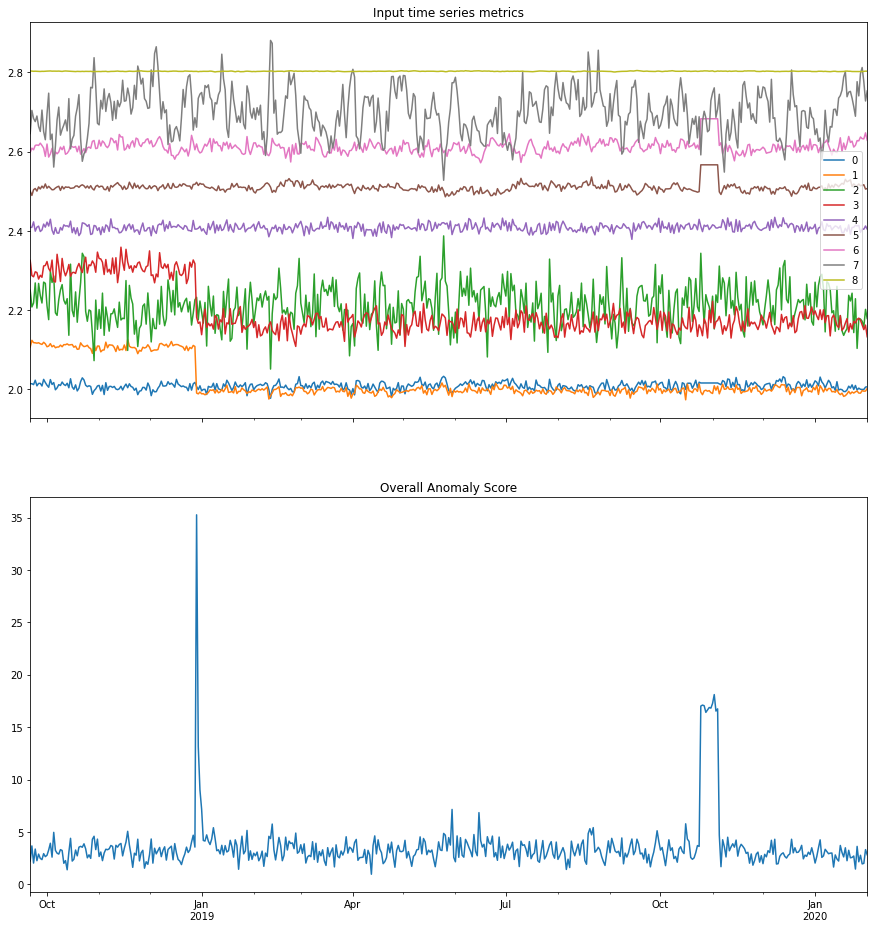

In [47]:
params = BayesianVARParams(p=2)
d = MultivariateAnomalyDetector(
    TSData_multi, 
    params, 
    training_days=500, 
    model_type=MultivariateAnomalyDetectorType.BAYESIAN_VAR)
anomaly_score_df = d.detector()
d.plot()

In [ ]:
logging.basicConfig(level=logging.INFO)

## **2.3 HourlyRatioDetector**

We observe that for some hourly-level time series related to user behavior (e.g., ALM), there may exist some intra-day irregular pattern (e.g., a time series usually achieves its maximum at 8 a.m., while it achieves its maximum at 10 a.m. on some days) and these days are strong indicators for holidays and big events. The HourlyRatioDetector is designed to detect those irregular patterns. The detailed methodology can be found at https://fb.workplace.com/notes/yang-yu/detecting-abnormal-intra-day-fb-alm/136760347595586/.

### Parameters when initial the detector
* **data**: TimeSeriesData, the data to be examed. It should have hour-level granularity.
* **freq**: Optional\[str], the data frequency (following the naming conventions of pandas). This will be inferred if it is not specified by user. Should be at least of hourly granularity.Common frequency expressions:
    * 'H': hourly frequency
    * 'T': minutely frequency
    * 'S': secondly frequency
* **aggregate**: Optional\[str], aggreate method (for data with finer granularity than hourly-level)

### Basic usage
In this notebook, we use the ALM data of US in 2007 as an example.

In [48]:
# we need a data to demo this detector
# TODO

# 3. Trend detection
Trend detection tries to identify significant and prolonged changes in a time series. Similar with change point detection, trend detection also looks for changes. But it is different to change point detection in:
1. Trend detection doesn't look for change point, it is an analysis that looks for the existence of gradual departure of data from its past;
2. Trend detection detects long-term changed, like a slow drift, while change point is trying to detect short-term changed, like a step change;

### Parameters when initial the detector
* **data**: TimeSeriesData, this is time series data at one-day granularity. This time series can be either univariate or multivariate. We require more than training_days points in each time series.
* **threshold**: float, threshold for trend intensity; higher threshold gives trend with high intensity (0.8 by default)
* **alpha**: float, significance level (0.05 by default)s
* **multivariate**: bool, whether the input time series is multivariate

### Parameters for detector( ) method
* **window_size**: int, the number of look back days for checking trend persistence (20 days by default)

* **training_days**: int, the number of days for time series smoothing; should be greater or equal to window_size (None by default). If training_days is None, we will perform trend detection on the whole time series; otherwise, we will perform trend detection only for the anchor point using the previous training_days data.

* **direction**: string, the direction of the trend to be detected, choose from {"down", "up", "both"}  ("both" by default)

* **freq**: str, the type of seasonality shown in the time series, choose from {'weekly','monthly','yearly'} (None by default)

### Basic usage

In [53]:
# synthesize data with simulation
from scipy.special import expit
def gen_ts(
    initial=10000.0,
    trend=40.0,
    trend_change=-60.0,
    seasonality=0.07,  # multiplicative seasonality
    noise=0.005,  # multiplicative cumulative noise
    n_days=365,
    t_change=250,
    change_smoothness=5.0,
):
    """Generate a sample time series with a trend change, noise, and seasonality"""
    ix = np.arange(n_days)
    data = (
        (
            initial
            + trend * ix
            + trend_change * (ix - t_change) * expit((ix - t_change))
        )
        * (1 - seasonality * (ix % 7 >=5))  # Subtract for saturday and sunday
        * np.cumprod(1 + noise * np.random.randn(n_days)))
    
    t = pd.date_range(start='2020-01-01', periods=n_days, freq='1D')
    return pd.DataFrame({"time":t, "value": data})
tsd = TimeSeriesData(gen_ts())

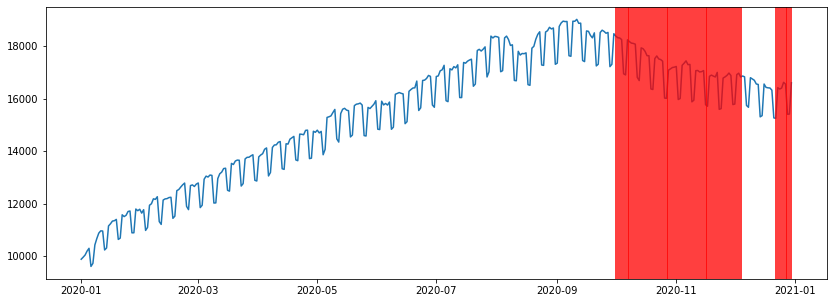

In [54]:
from kats.detectors.trend_mk import MKDetector

detector = MKDetector(data=tsd, threshold=.8)
# run detector
detected_time_points = detector.detector(direction='down', window_size=20, freq='weekly')
# plot the results
detector.plot(detected_time_points)

### Interpret the results
The detector method returns `List[Tuple[TimeSeriesChangePoint, MKMetadata]]`

In [55]:
cp, meta = detected_time_points[0]
cp

TimeSeriesChangePoint(start_time: 2020-10-01 00:00:00, end_time: 2020-10-01 00:00:00, confidence: 0.9999999136388094)

### Multivariate 
In the case of multivariate as input, the algorithm performs the Multivariate Mann-Kendall (MK) test proposed by R. M. Hirsch and J. R. Slack (1984).

# we need a data to demo this detector